<a href="https://colab.research.google.com/github/lorenzopasquetto/Projects-2023-2024/blob/main/BinaryClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2023-2024] AN2DL/...

Mounted at /gdrive
/gdrive/My Drive/[2023-2024] AN2DL/...

In [ ]:
seed = 50

#Import all the libraries

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
from tensorflow.keras.applications.mobilenet import preprocess_input
print(tf.__version__)


from keras.models import load_model


from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape, InputLayer, Flatten
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.xception import preprocess_input
#from tensorflow.keras.applications.efficient import preprocess_input
#from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


#tfk.applications.InceptionV3

# Import other libraries
import cv2

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight

import seaborn as sns
from sklearn.model_selection import KFold


2.15.0


In [ ]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')
#tf.keras.mixed_precision.set_global_policy.(policy)

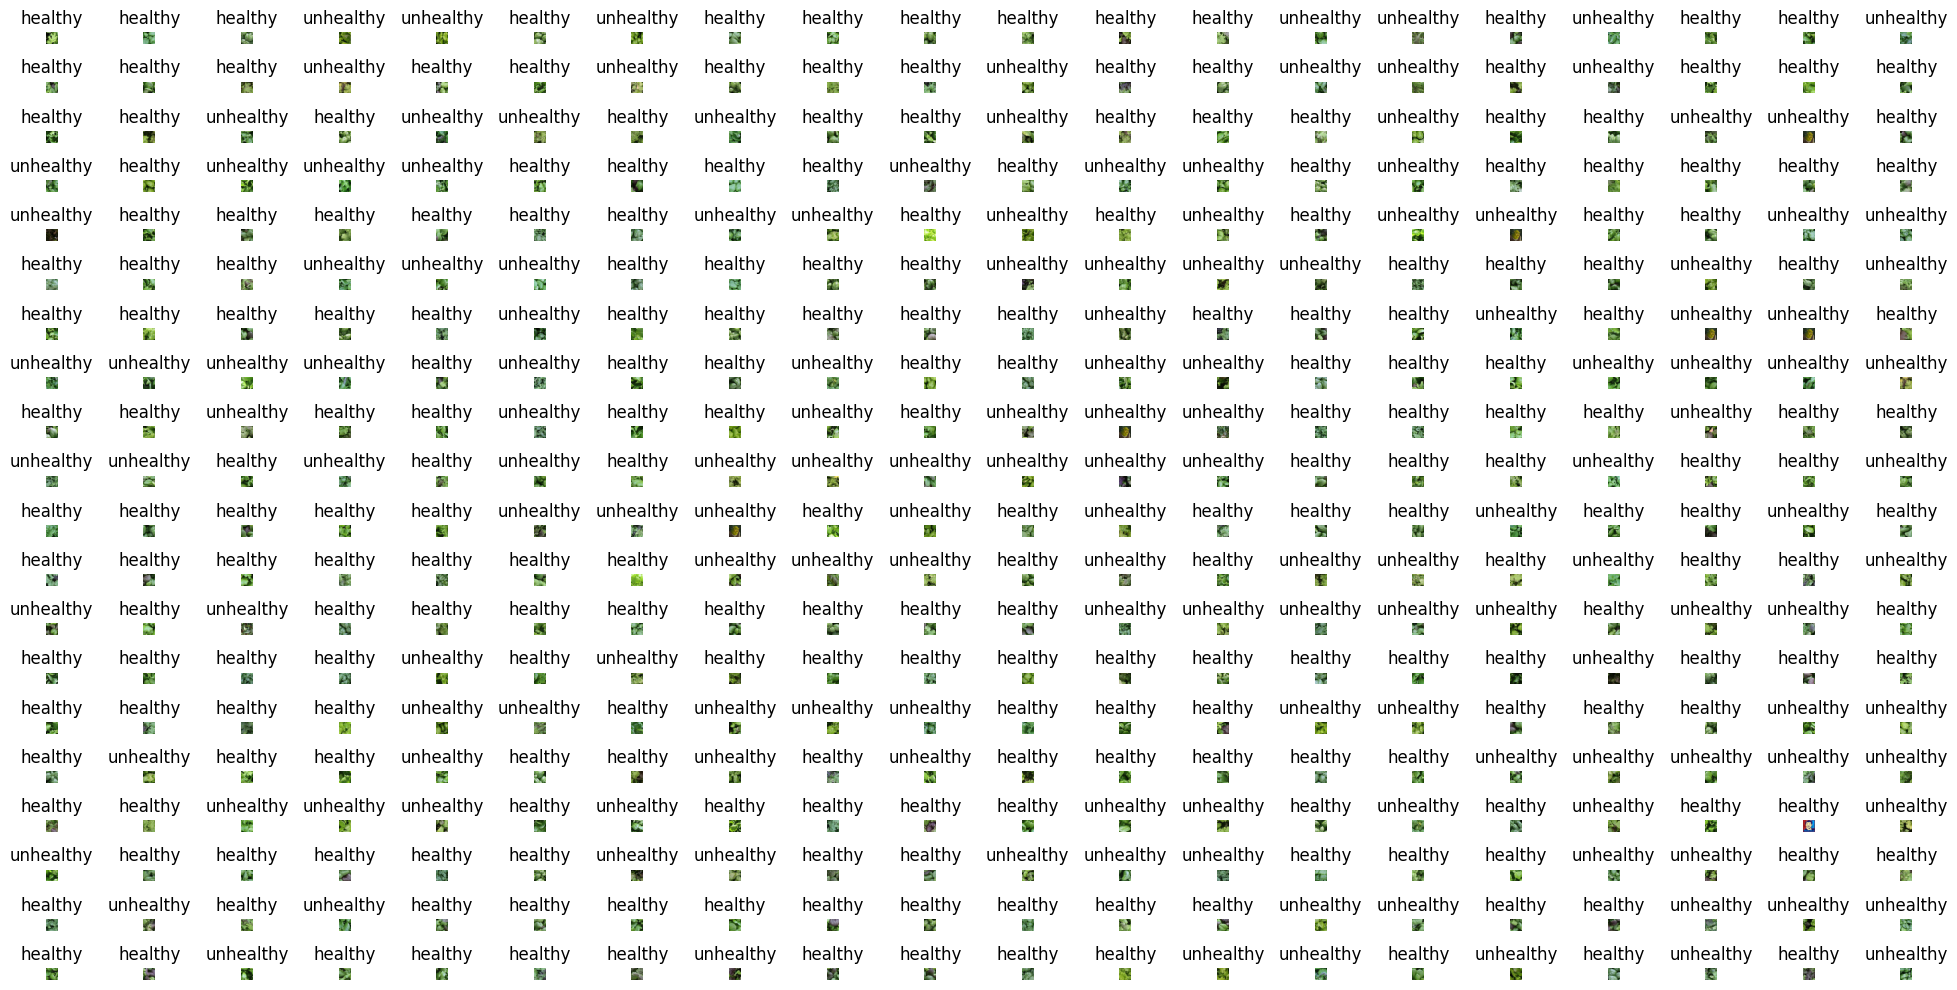

In [ ]:
data = np.load('public_data.npz', allow_pickle=True)
X_data = (data['data']/255).astype('float32')
labels = data['labels']
plot_image_lab(X_data, labels, 50)

In [ ]:
#FUNCTIONS

def plot_image_lab(X_data, label, num_images):

    # Generate 200 random images and corresponding labels
    #num_images = 20
    image_size = (96, 96)

    # Display the images with labels
    fig, axes = plt.subplots(20, 20, figsize=(20, 10))

    for i, ax in enumerate(axes.ravel()):
        ax.imshow(X_data[i])
        ax.set_title(f'{label[i]}')  # Set the title as the label
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def calculate_hash(image):
    # Convert the image to a hashable string representation
    image_str = image.tostring()
    # Calculate the hash value using Python's built-in hash function
    return hash(image_str)



#Import Data

data = np.load('public_data.npz', allow_pickle=True)

#Images and Labels splitting plus normalization

X_data = (data['data']/255).astype('float32')
labels = data['labels']
#print("original dimensions: ", Init_data.shape )

Init_data = X_data
Init_labels  = labels
images = X_data

#Remove duplicates
# Create an empty set to store unique hash values
unique_hashes = set()

# Create an empty list to store indices of unique images
unique_indices = []


# Iterate through the array of RGB images and remove duplicates
for idx, image in enumerate(images):
    hash_value = calculate_hash(image)
    hash_label_tuple = (hash_value, labels[idx])
    # If the hash value is not in the set, add it to the set and the unique indices list
    if hash_label_tuple not in unique_hashes:
        unique_hashes.add(hash_label_tuple)
        unique_indices.append(idx)

# Create a new NumPy array containing only the unique RGB images
unique_images = images[unique_indices]
unique_labels = labels[unique_indices]


# Create a new NumPy array containing only the unique images

clean2_X_data = unique_images
clean2_labels = unique_labels
print(unique_images.shape, X_data.shape, type(X_data), type(clean2_X_data))
print(clean2_X_data.shape, clean2_labels.shape)



#Delete the remaining outliers in position 58 and 327

clean2_X_data = np.delete(clean2_X_data, 58, axis=0)
clean2_labels = np.delete(clean2_labels, 58, axis=0)
#plot_image_lab(clean2_X_data, clean2_labels, 40)

clean2_X_data = np.delete(clean2_X_data, 327, axis=0)
clean2_labels = np.delete(clean2_labels, 327, axis=0)
#plot_image_lab(clean2_X_data, clean2_labels, 80)


# Mapping function to convert "black" to 0 and "white" to 1
bv = [0 if i == "healthy" else 1 for i in clean2_labels]

bv_a = np.array(bv)

y = tfk.utils.to_categorical(bv_a,len(np.unique(bv_a)))
print("Dimension of data set: ", clean2_X_data.shape)
print(y.shape)

(4852, 96, 96, 3) (5200, 96, 96, 3) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(4852, 96, 96, 3) (4852,)
Dimension of data set:  (4850, 96, 96, 3)
(4850, 2)


In [ ]:
def num_unheal(y_kF):
    count_1 = 0
    count_0 = 0

    for i in y_kF:
        #print(i)
        if i[0] == 1: count_0 = count_0 + 1
        else: count_1 = count_1 + 1
    print("number of healthy: ",count_0)
    print("number of unhealthy: ",count_1)

    unb = count_0 - count_1
    print("Unbalance: ",unb)
    return unb


In [ ]:
X_data = clean2_X_data

num_unheal(y)

number of healthy:  3060
number of unhealthy:  1790
Unbalance:  1270


1270

In [ ]:
ind_h = []
ind_un = []
X_s = []

for num, i in enumerate(y):
  if i[0] == 0:
    ind_un.append(num)
  else: ind_h.append(num)

X_h = X_data[ind_h]
y_h = y[ind_h]
X_un = X_data[ind_un]
y_un = y[ind_un]
#X_neg = X_data[]


In [ ]:
# Definition of test set
X_test_un = X_un[:20]
y_test_un = y_un[:20]
X_test_h = X_h[:100]
y_test_h = y_h[:100]
#X_test_h = X_h[:190]
#y_test_h = y_h[:190]

In [ ]:
X_test = X_data[:20]
y_test = y[:20]


In [ ]:
X_data = X_data[20:]
y_data = y[20:]


In [ ]:
X_test = np.concatenate([X_test_un, X_test_h], axis = 0)

y_test = np.concatenate([y_test_un, y_test_h], axis = 0)

print(X_test.shape, y_test.shape)

(120, 96, 96, 3) (120, 2)


In [ ]:
X_test = X_test[:40]
y_test = y_test[:40]

In [ ]:
num_unheal(y_test)

number of healthy:  13
number of unhealthy:  7
Unbalance:  6


6

In [ ]:
X_additional = X_h[190:1460]
y_additional = y_h[190:1460]
X_additional.shape

(1270, 96, 96, 3)

In [ ]:
X_data = np.concatenate([X_un[20:], X_h[100:]], axis = 0)
y_data = np.concatenate([y_un[20:], y_h[100:]], axis = 0)


In [ ]:
print(X_data.shape, y_data.shape)

(4830, 96, 96, 3) (4830, 2)


In [ ]:
num_unheal(y_data)

number of healthy:  3047
number of unhealthy:  1783
Unbalance:  1264


1264

In [ ]:
# Twice the unhelathy data with data augmentation

X_add = np.concatenate([X_un[7:400], X_h[13:480]], axis = 0)
print(X_add.shape)
y_add = np.concatenate([y_un[7:400], y_h[13:480]], axis = 0)
print(y_add.shape)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed,),
    tf.keras.layers.RandomRotation(0.6, seed = seed),
    tf.keras.layers.RandomCrop(9, 9, seed=seed),
    tf.keras.layers.RandomBrightness([0.2, 0.7], seed = seed )

])

for i in X_add:
    i = data_augmentation(i)

X_kF_nn = np.concatenate((X_data,X_add), axis=0)
y_kF_nn = np.concatenate((y_data,y_add), axis = 0)
print("Final shape: ",X_kF_nn.shape,
y_kF_nn.shape)






(860, 96, 96, 3)
(860, 2)
Final shape:  (5690, 96, 96, 3) (5690, 2)


In [ ]:
num_unheal(y_kF_nn)
print(X_kF_nn.shape, y_kF_nn.shape)


number of healthy:  3340
number of unhealthy:  2150
Unbalance:  1190
(5490, 96, 96, 3) (5490, 2)


In [ ]:
X_data = X_kF_nn
y_data = y_kF_nn

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, random_state=seed, test_size = 0.30)

In [ ]:
X_train1 = np.concatenate([X_additional, X_train], axis = 0)
y_train1 = np.concatenate([y_additional, y_train], axis = 0)

In [ ]:
X_train = X_train1
y_train = y_train1

In [ ]:
print(X_train.shape, y_train.shape)

(3843, 96, 96, 3) (3843, 2)


In [ ]:
# Twice the data with data augmentation

X_add = X_train
print(X_add.shape)
y_add = y_train
print(y_add.shape)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed,),
    tf.keras.layers.RandomRotation(0.43, seed = seed),
    tf.keras.layers.RandomCrop(27, 67, seed=seed),
    tf.keras.layers.RandomBrightness([0.2, 0.7], seed = seed )

])

for i in X_add:
    i = data_augmentation(i)

X_kF_nn = np.concatenate((X_data,X_add), axis=0)
y_kF_nn = np.concatenate((y_data,y_add), axis = 0)
print("Final shape: ",X_kF_nn.shape,
y_kF_nn.shape)


(4550, 96, 96, 3)
(4550, 2)
Final shape:  (11050, 96, 96, 3) (11050, 2)


In [ ]:
#####################---------------------------

In [ ]:



# Split train_val into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y, random_state=seed, test_size=0.20)

X_kF = X_train
y_kF = y_train
# Split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=seed, test_size = 0.30)
print("Initial dimension of data set: ", X_data.shape, y.shape)
print("Train data and labels: ", X_train.shape, y_train.shape)
print("Validation data and labels: ", X_val.shape, y_val.shape)
print("Test dataset to performe inference: ", X_test.shape, y_test.shape)

print("Kcross validation sets: ", X_kF.shape, y_kF.shape)


#Definition of callbacks
patience=60
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=60, restore_best_weights=True, mode='auto'),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=50)
]



Initial dimension of data set:  (4850, 96, 96, 3) (4850, 2)
Train data and labels:  (2716, 96, 96, 3) (2716, 2)
Validation data and labels:  (1164, 96, 96, 3) (1164, 2)
Test dataset to performe inference:  (970, 96, 96, 3) (970, 2)
Kcross validation sets:  (3880, 96, 96, 3) (3880, 2)


In [ ]:
count_1 = 0
count_0 = 0

for i in y_kF:
    #print(i)
    if i[0] == 1: count_0 = count_0 + 1
    else: count_1 = count_1 + 1
print("number of healthy: ",count_0)
print("number of unhealthy: ",count_1)

unb = count_0 - count_1
print("Unbalance: ",unb)

number of healthy:  2450
number of unhealthy:  1430
Unbalance:  1020


In [ ]:
# Creation of balanced validation set
ind_unh = []
X_syn = []
for num, j in enumerate(y_kF):
    if j[0] == 0: ind_unh.append(num)
    #print(num, j)

X_en = X_kF[ind_unh]
y_en = y_kF[ind_unh]

X_ex_un = X_en[:429]
y_ex_un = y_en[:429]

ind_hea = []
X_syn = []
for num, j in enumerate(y_kF):
    if j[0] == 1: ind_hea.append(num)
    #print(num, j)

X_en = X_kF[ind_hea]
y_en = y_kF[ind_hea]

X_ex_hea = X_en[:429]
y_ex_hea = y_en[:429]

X_val_bal = np.concatenate((X_ex_un,X_ex_hea), axis=0)
y_val_bal = np.concatenate((y_ex_un,y_ex_hea), axis=0)

In [ ]:
print(num_unheal(y_val_bal))

number of healthy:  429
number of unhealthy:  429
Unbalance:  0
0


In [ ]:
# Creation of Training set

ind_unh = []
X_syn = []
for num, j in enumerate(y_kF):
    if j[0] == 0: ind_unh.append(num)
    #print(num, j)

X_en = X_kF[ind_unh]
y_en = y_kF[ind_unh]

X_ex_un = X_en[429:]
y_ex_un = y_en[429:]

ind_hea = []
X_syn = []
for num, j in enumerate(y_kF):
    if j[0] == 1: ind_hea.append(num)
    #print(num, j)

X_en = X_kF[ind_hea]
y_en = y_kF[ind_hea]

X_ex_hea = X_en[429:]
y_ex_hea = y_en[429:]

# Concatenation of healty/unhealthy

X_train_unbal = np.concatenate((X_ex_un,X_ex_hea), axis=0)
y_train_unbal = np.concatenate((y_ex_un,y_ex_hea), axis=0)

In [ ]:
num_unheal(y_train_unbal)

number of healthy:  2021
number of unhealthy:  1001
Unbalance:  1020


1020

In [ ]:
# TRYING TO BALANCE VAL DATA USING IMAGE AUGMENTATION

count_1 = 0
count_0 = 0

for i in y_val:
    #print(i)
    if i[0] == 1: count_0 = count_0 + 1
    else: count_1 = count_1 + 1
print("number of healthy: ",count_0)
print("number of unhealthy: ",count_1)

unb = count_0 - count_1
print("Unbalance: ",unb)

ind = []
X_syn = []
for num, j in enumerate(y_val):
    if j[0] == 0: ind.append(num)
    #print(num, j)

X_en = X_val[ind]
y_en = y_val[ind]

X_ex = X_en[:unb]
y_ex = y_en[:unb]

print("Enhanced dataset: ", X_ex.shape, y_ex.shape)

# EXTERNAL DATASET X_ex WITH AUG IMAGES
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.3),
  tfkl.RandomZoom(0.1),
  #tfkl.RandomContrast(0.75)
])

for i in X_ex:
    i = data_augmentation(i)



number of healthy:  751
number of unhealthy:  413
Unbalance:  338
Enhanced dataset:  (338, 96, 96, 3) (338, 2)


In [ ]:
#Concatenate to the initial dataset

X_val_b = np.concatenate((X_val,X_ex), axis=0)
y_val_b = np.concatenate((y_val,y_ex), axis = 0)

print("Final shape: ",X_val_b.shape,
y_val_b.shape)

Final shape:  (1502, 96, 96, 3) (1502, 2)


In [ ]:
num_unheal(y_val_b)

number of healthy:  751
number of unhealthy:  751
Unbalance:  0


0

In [ ]:
# TRY TO BALANCE TRAIN DATA USING IMAGE AUGMENTATION

count_1 = 0
count_0 = 0

for i in y_train:
    #print(i)
    if i[0] == 1: count_0 = count_0 + 1
    else: count_1 = count_1 + 1
print("number of healthy: ",count_0)
print("number of unhealthy: ",count_1)

unb = count_0 - count_1
print("Unbalance: ",unb)

ind = []
X_syn = []
for num, j in enumerate(y_train):
    if j[0] == 0: ind.append(num)
    #print(num, j)

X_en = X_train[ind]
y_en = y_train[ind]

X_ex = X_en[:unb]
y_ex = y_en[:unb]

print("Enhanced dataset: ", X_ex.shape, y_ex.shape)

# EXTERNAL DATASET X_ex WITH AUG IMAGES
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.3),
  tfkl.RandomZoom(0.1),
  #tfkl.RandomContrast(0.75)
])

for i in X_ex:
    i = data_augmentation(i)


#Concatenate to the initial dataset

X_train_b = np.concatenate((X_train,X_ex), axis=0)
y_train_b = np.concatenate((y_train,y_ex), axis = 0)

print("Final shape: ",X_train_b.shape,
y_train_b.shape)

number of healthy:  1699
number of unhealthy:  1017
Unbalance:  682
Enhanced dataset:  (682, 96, 96, 3) (682, 2)
Final shape:  (3398, 96, 96, 3) (3398, 2)


In [ ]:
#Balance val data

count_1 = 0
count_0 = 0

for i in y_val:
    #print(i)
    if i[0] == 1: count_0 = count_0 + 1
    else: count_1 = count_1 + 1
print("number of healthy: ",count_0)
print("number of unhealthy: ",count_1)

unb = count_0 - count_1
print("Unbalance: ",unb)

ind = []
X_syn = []
for num, j in enumerate(y_val):
    if j[0] == 0: ind.append(num)
    #print(num, j)

X_en = X_val[ind]
y_en = y_val[ind]

X_ex = X_en[:unb]
y_ex = y_en[:unb]

print("Enhanced dataset: ", X_ex.shape, y_ex.shape)

# EXTERNAL DATASET X_ex WITH AUG IMAGES
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.3),
  tfkl.RandomZoom(0.1),
  #tfkl.RandomContrast(0.75)
])

for i in X_ex:
    i = data_augmentation(i)


#Concatenate to the initial dataset

X_val_b = np.concatenate((X_val,X_ex), axis=0)
y_val_b = np.concatenate((y_val,y_ex), axis = 0)

print("Final shape: ",X_val_b.shape,
y_val_b.shape)

number of healthy:  751
number of unhealthy:  413
Unbalance:  338
Enhanced dataset:  (338, 96, 96, 3) (338, 2)
Final shape:  (1502, 96, 96, 3) (1502, 2)


In [ ]:
y_val = y_val_b
X_val = X_val_b

In [ ]:
count_1 = 0
count_0 = 0

for i in y_train_b:
    #print(i)
    if i[0] == 1: count_0 = count_0 + 1
    else: count_1 = count_1 + 1
print("number of healthy: ",count_0)
print("number of unhealthy: ",count_1)

unb = count_0 - count_1
print("Unbalance: ",unb)
X_train = X_train_b

number of healthy:  1699
number of unhealthy:  1699
Unbalance:  0


In [ ]:
X_train = X_train_b
y_train = y_train_b

In [ ]:
#######################_____________---------

In [ ]:
del model

In [ ]:
xception = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",

    input_shape=(96,96,3),
    pooling='avg',

    classifier_activation="sigmoid",
)

In [ ]:
mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
)



9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
efficient = tf.keras.applications.efficientnet_v2.EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    #input_tensor=None,
    input_shape=(96,96,3),
    pooling='avg',
    #classes=1000,
    classifier_activation='sigmoid',
    include_preprocessing=True
)

82420632/82420632 [==============================] - 4s 0us/step


In [ ]:
conv_small = tf.keras.applications.ConvNeXtSmall(
    model_name="convnext_small",
    include_top=False,
    include_preprocessing=True,
    weights="imagenet",
    #input_tensor=None,
    input_shape=(96,96,3),
    pooling='avg',
    #classes=1000,
    classifier_activation="sigmoid",
)

198551472/198551472 [==============================] - 10s 0us/step


In [ ]:
conv_base = tf.keras.applications.ConvNeXtBase(
    model_name="convnext_base",
    include_top=False,
    include_preprocessing=True,
    weights="imagenet",
    #input_tensor=None,
    input_shape=(96, 96, 3),
    pooling='avg',
    #classes=1000,
    classifier_activation="sigmoid",
)

350926856/350926856 [==============================] - 17s 0us/step


In [ ]:
del model

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.5),
])


input_layer = tfk.Input(shape = (96,96,3))
#global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
x = data_augmentation(input_layer)
x = efficient(input_layer)
x = tfkl.Flatten()(x)


x = tfkl.Dense(40)(x)
x = tfkl.Dense(10)(x)
#x = global_average_layer(x)
dropout = tfkl.Dropout(0.4)(x)
output_layer = tfkl.Dense(2, activation='sigmoid')(dropout)

model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-s (Function  (None, 1280)              20331360  
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 40)                51240     
                                                                 
 dense_1 (Dense)             (None, 10)                410       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                             

In [ ]:
base_learning_rate = 0.01

#y_integers = np.argmax(y_train, axis=1)
#class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
#d_class_weights = dict(enumerate(class_weights))

#sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

#class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
model.get_layer('efficientnetv2-s').trainable = False
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-s (Function  (None, 1280)              20331360  
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 40)                51240     
                                                                 
 dense_1 (Dense)             (None, 10)                410       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                             

In [ ]:
history = model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 32,
    epochs = 200,
    #sample_weight=sample_weights,
    validation_data = ((preprocess_input(X_val*255), y_val)), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau( monitor="val_accuracy", factor=0.1, patience=10, verbose=0, mode="auto", cooldown=0, min_lr=1e-12,)]
).history

Epoch 1/200
125/125 [==============================] - 121s 409ms/step - loss: 0.7885 - accuracy: 0.5825 - val_loss: 0.6648 - val_accuracy: 0.6262 - lr: 0.0100
Epoch 2/200
125/125 [==============================] - 14s 115ms/step - loss: 0.6733 - accuracy: 0.6126 - val_loss: 0.6617 - val_accuracy: 0.6262 - lr: 0.0100
Epoch 3/200
125/125 [==============================] - 15s 118ms/step - loss: 0.6680 - accuracy: 0.6121 - val_loss: 0.6628 - val_accuracy: 0.6262 - lr: 0.0100
Epoch 4/200
125/125 [==============================] - 15s 117ms/step - loss: 0.6646 - accuracy: 0.6181 - val_loss: 0.6629 - val_accuracy: 0.6262 - lr: 0.0100
Epoch 5/200
125/125 [==============================] - 14s 113ms/step - loss: 0.6588 - accuracy: 0.6191 - val_loss: 0.6683 - val_accuracy: 0.6262 - lr: 0.0100
Epoch 6/200
125/125 [==============================] - 14s 113ms/step - loss: 0.6544 - accuracy: 0.6289 - val_loss: 0.7191 - val_accuracy: 0.3743 - lr: 0.0100
Epoch 7/200
125/125 [========================

In [ ]:
#model.get_layer('xception').trainable = False
for i, layer in enumerate(model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)

model.summary()

0 input_6 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d_4 False
13 block2_pool False
14 batch_normalization_4 False
15 add_12 False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_5 False
23 block3_pool False
24 batch_normalization_5 False
25 add_13 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_6 False
33 block4_pool False
34 batch_normalization_6 False
35 add_14 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepco

In [ ]:
xception.trainable = True

N = 133

for i in model.get_layer('xception').layers:
    i.trainable = False


for i, layer in enumerate(model.get_layer('xception').layers[126:N]):
   layer.trainable = True

for i, layer in enumerate(model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)

model.summary()

0 input_6 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d_4 False
13 block2_pool False
14 batch_normalization_4 False
15 add_12 False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_5 False
23 block3_pool False
24 batch_normalization_5 False
25 add_13 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_6 False
33 block4_pool False
34 batch_normalization_6 False
35 add_14 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepco

In [ ]:
print(X_train.shape)
print(y_train.shape)
num_unheal(y_train)

print(X_val.shape)
print(y_val.shape)
num_unheal(y_val)

(4480, 96, 96, 3)
(4480, 2)
number of healthy:  2232
number of unhealthy:  2248
Unbalance:  -16
(1920, 96, 96, 3)
(1920, 2)
number of healthy:  968
number of unhealthy:  952
Unbalance:  16


16

In [ ]:
model.save('conv_model_aug')

In [ ]:
score = model.evaluate(preprocess_input(X_test*255), y_test, verbose=0)

i=score
print("loss1: ",i[0])
print("accuracy1: ", i[1])

loss1:  0.6690219044685364
accuracy1:  0.8500000238418579


First:
loss1:  0.38882607221603394
accuracy1:  0.8947368264198303

Second: loss1:  0.2707647979259491
accuracy1:  0.8921052813529968

In [ ]:
model.save('model_colab_bbFT')

In [ ]:
# Predict labels for the entire test set
predictions = model.predict(preprocess_input(X_test*255), verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (20, 2)


In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')


Accuracy: 0.8
Precision: 0.8
Recall: 0.7473
F1: 0.7619


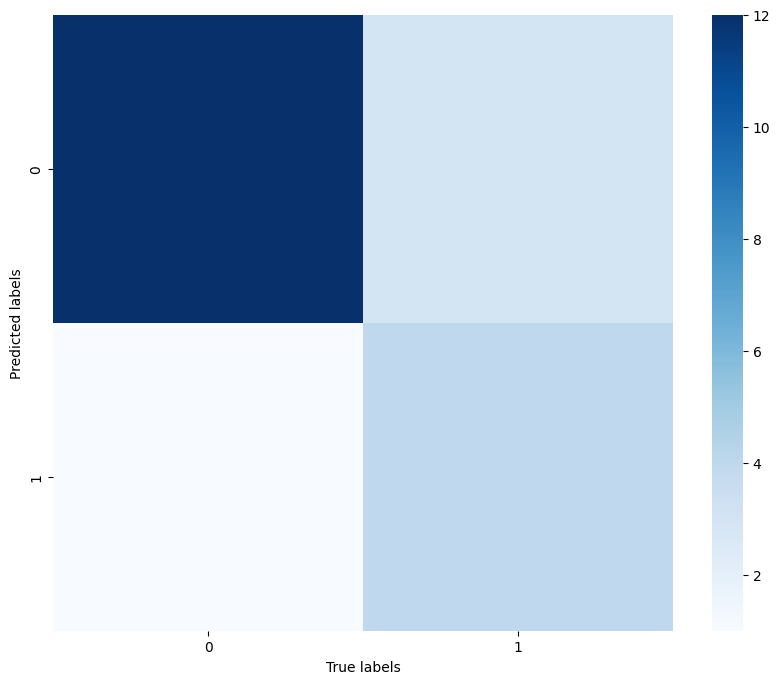

In [ ]:

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list([0,1]), yticklabels=list([0,1]), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
models=[]

model1 = load_model('model_colab_FT')
model2 = load_model('model_colab_bbFT')

In [ ]:
models.append(model1)
models.append(model2)

In [ ]:
output_model1 = model1.output
output_model2 = model2.output
#output_model3 = model3.output
#output_model4 = model4.output
#output_model5 = model5.output


#input_layer = tfk.Input(shape = (96,96,3))
# Concatenate the outputs along the last axis (axis=-1)
merged_outputs = tfkl.Concatenate(axis=-1)([output_model1, output_model2])
# Add an output layer for binary classification
#ensemble_output = Dense(2, activation='sigmoid')(merged_outputs)
# Ottieni l'uscita degli ultimi layer dei tre modelli

output_model1 = model1.layers[-1].output
output_model2 = model2.layers[-1].output
#output_model3 = model3.layers[-1].output
#output_model4 = model4.layers[-1].output
#output_model5= model5.layers[-1].output

# Calcola la media delle uscite
average_outputs = tfkl.Average()([output_model1, output_model2])
ensemble_model = tfk.Model(inputs=[model1.input, model2.input], outputs=average_outputs)

#ensemble_model = tfk.Model(inputs=[model1.input, model2.input, model3.input], outputs=ensemble_output)
# Compile the ensemble model (you may need to adjust the optimizer, loss, and metrics based on your problem)
#ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
del model1
del model2

In [ ]:
X_pre = [preprocess_input(X_test*255), preprocess_input(X_test*255)]

score = ensemble_model.evaluate(X_pre, y_test, verbose=0)

i=score
print("loss1: ",i[0])
print("accuracy1: ", i[1])

loss1:  0.0679931640625
accuracy1:  0.949999988079071


In [ ]:
del i

In [ ]:
# Predict labels for the entire test set
predictions = ensemble_model.predict(X_pre, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (20, 2)


In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')


Accuracy: 0.95
Precision: 0.9375
Recall: 0.9615
F1: 0.9467


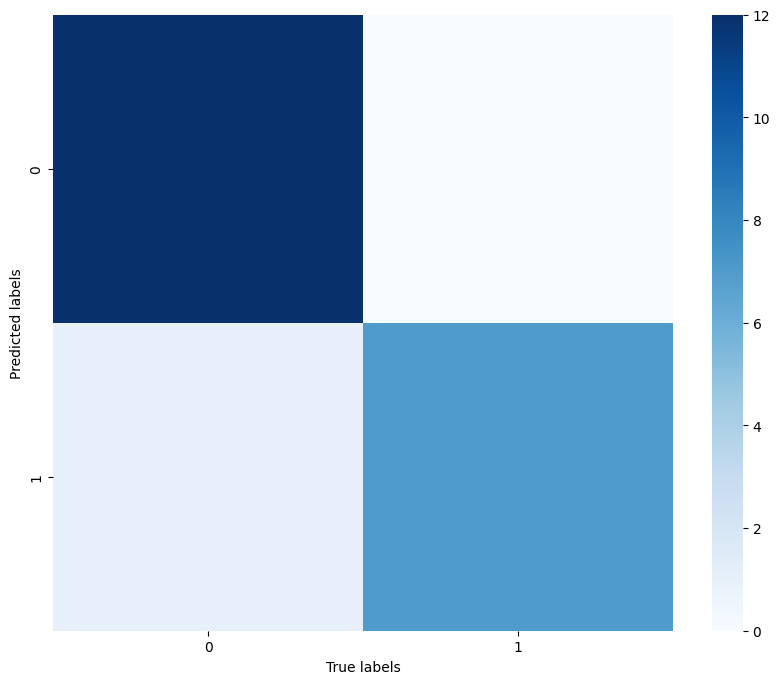

In [ ]:
# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list([0,1]), yticklabels=list([0,1]), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
ensemble_model.save('ti_prego_vai')

In [ ]:
model1 = load_model('ti_prego_vai')

In [ ]:
ensemble_model.trainable = False


In [ ]:
base_learning_rate = 0.00001
.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 96, 96, 3)            0         ['input_2[0][0]']             
                                                                                                  
 sequential_5 (Sequential)   (None, 96, 96, 3)            0         ['input_6[0][0]']             
                                                                                              

In [ ]:
tfk.utils.plot_model(ensemble_model)

In [ ]:
history = ensemble_model.fit(
    x = [preprocess_input(X_train*255), preprocess_input(X_train*255)],# We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 64,
    epochs = 200,
    #sample_weight=sample_weights,
    validation_data = ([preprocess_input(X_val*255),preprocess_input(X_val*255)], y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    #min_delta=0.0001,
    cooldown=0,
    min_lr=1e-12,

)
]
).history


Epoch 1/200
70/70 [==============================] - 26s 153ms/step - loss: 0.1172 - accuracy: 0.9647 - val_loss: 0.0991 - val_accuracy: 0.9745 - lr: 1.0000e-05
Epoch 2/200
70/70 [==============================] - 5s 73ms/step - loss: 0.1171 - accuracy: 0.9618 - val_loss: 0.0991 - val_accuracy: 0.9745 - lr: 1.0000e-05
Epoch 3/200
70/70 [==============================] - 5s 72ms/step - loss: 0.1196 - accuracy: 0.9632 - val_loss: 0.0991 - val_accuracy: 0.9745 - lr: 1.0000e-05
Epoch 4/200
70/70 [==============================] - 5s 73ms/step - loss: 0.1254 - accuracy: 0.9632 - val_loss: 0.0991 - val_accuracy: 0.9745 - lr: 1.0000e-05
Epoch 5/200
70/70 [==============================] - 5s 74ms/step - loss: 0.1164 - accuracy: 0.9650 - val_loss: 0.0991 - val_accuracy: 0.9745 - lr: 1.0000e-05
Epoch 6/200
70/70 [==============================] - 5s 73ms/step - loss: 0.1175 - accuracy: 0.9665 - val_loss: 0.0991 - val_accuracy: 0.9745 - lr: 1.0000e-05
Epoch 7/200
70/70 [=========================

In [ ]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 96, 96, 3)            0         ['input_2[0][0]']             
                                                                                                  
 sequential_5 (Sequential)   (None, 96, 96, 3)            0         ['input_6[0][0]']             
                                                                                              

In [ ]:
X_pre = [preprocess_input(X_test*255), preprocess_input(X_test*255)]

In [ ]:
# Predict labels for the entire test set
predictions = model1.predict(X_pre, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (380, 2)


In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')


Accuracy: 0.9658
Precision: 0.9659
Recall: 0.9658
F1: 0.9658


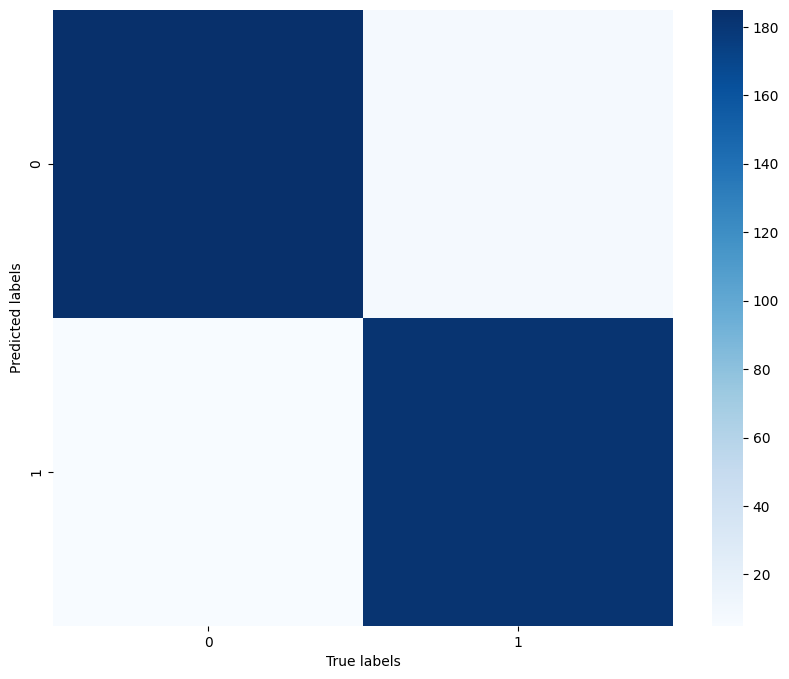

In [ ]:
# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list([0,1]), yticklabels=list([0,1]), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
#ensemble_model.summary()
ensemble_model.trainable = True
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 96, 96, 3)            0         ['input_2[0][0]']             
                                                                                                  
 sequential_5 (Sequential)   (None, 96, 96, 3)            0         ['input_6[0][0]']             
                                                                                              

In [ ]:
ensemble_model.get_layer('efficientnetv2-s').trainable = False
ensemble_model.get_layer('xception').trainable = False


In [ ]:
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 96, 96, 3)            0         ['input_2[0][0]']             
                                                                                                  
 sequential_5 (Sequential)   (None, 96, 96, 3)            0         ['input_6[0][0]']             
                                                                                              

In [ ]:
conv =tf.keras.applications.ConvNeXtLarge(
    model_name="convnext_large",

    include_top=False,

    include_preprocessing=True,

    weights="imagenet",

    input_shape=(96,96,3),

    classifier_activation="sigmoid",
)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.5),
])


input_layer = tfk.Input(shape = (96,96,3))
#global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
x = data_augmentation(input_layer)
x = conv(x)
#x = tfkl.Dense(70)(x)
#x = global_average_layer(x)
dropout = tfkl.Dropout(0.4)(x)
output_layer = tfkl.Dense(2, activation='sigmoid')(dropout)

model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential_5 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 convnext_large (Functional  (None, 3, 3, 1536)        196230336 
 )                                                               
                                                                 
 dropout_4 (Dropout)         (None, 3, 3, 1536)        0         
                                                                 
 dense_8 (Dense)             (None, 3, 3, 2)           3074      
                                                                 
Total params: 196233410 (748.57 MB)
Trainable params: 3074 (12.01 KB)
Non-trainable params: 196230336 (748.56 MB)
_____________

In [ ]:
base_learning_rate = 0.001

#y_integers = np.argmax(y_train, axis=1)
#class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
#d_class_weights = dict(enumerate(class_weights))

#sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

#class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
model.get_layer('convnext_large').trainable = False
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential_5 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 convnext_large (Functional  (None, 3, 3, 1536)        196230336 
 )                                                               
                                                                 
 dropout_4 (Dropout)         (None, 3, 3, 1536)        0         
                                                                 
 dense_8 (Dense)             (None, 3, 3, 2)           3074      
                                                                 
Total params: 196233410 (748.57 MB)
Trainable params: 3074 (12.01 KB)
Non-trainable params: 196230336 (748.56 MB)
_____________